<a href="https://colab.research.google.com/github/Gilf641/EVA4/blob/master/S11/S11_Assignment(HalfBaked).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Mount your G-Drive**

In [1]:
from __future__ import print_function
%matplotlib inline

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


**Add Library Path in your def search path**

In [2]:
import sys
sys.path.append('/content/drive/My Drive/EVA4/updLib2/evaLibrary')
!ls '/content/drive/My Drive/EVA4/updLib2/evaLibrary'

AlbTestTransforms.py   customNet.py    execute.py    resNet.py
AlbTrainTransforms.py  cyclicLR.py     Gradcam.py    rohan_library.py
albumentations.py      DataLoaders.py  LR_Finder.py
all.py		       displayData.py  __pycache__


In [0]:
# !pip install torch-lr-finder -v --global-option="amp"

**Import required libraries**

In [4]:
from rohan_library import *
import execute
from resNet import ResNet18
import displayData as display
import Gradcam as gdc
import albumentations as alb
import DataLoaders as loader
import AlbTestTransforms
import AlbTrainTransforms
import LR_Finder as lrf
import cyclicLR as clr
import customNet

  pip install torch-lr-finder -v --global-option="amp"


**Albumentations**

In [0]:
albTrain = AlbTrainTransforms.train_transforms()
albTest = AlbTestTransforms.test_transforms()

**Load the Datasets**

In [6]:
train = torchvision.datasets.CIFAR10(root = './data', train = True, download = True, transform = albTrain)
test = torchvision.datasets.CIFAR10(root = './data', train = False, download = True, transform = albTest)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


**DataLoader for Train & Test Dataset**

In [0]:
dl = loader.DataLoaders(batch_size=512)
trainLoader = dl.dataLoader(train)
testLoader = dl.dataLoader(test)


In [8]:
dataiter = iter(trainLoader)

images, labels = dataiter.next()
print(images.shape)
print(labels.shape)

torch.Size([512, 3, 32, 32])
torch.Size([512])


**Displaying Random Images**

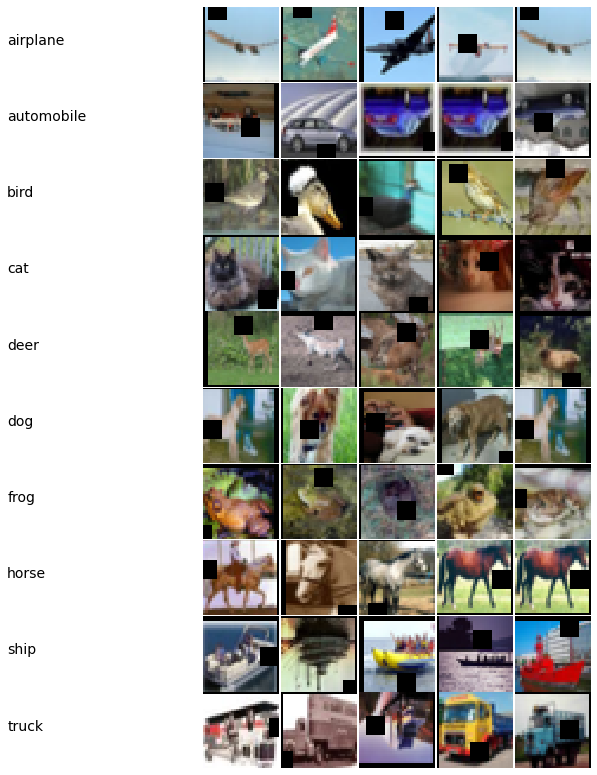

In [9]:
display.class_images(trainLoader)


**CustomNet**

In [10]:
from torchsummary import summary

use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')
print('Device set to ', device)

model = customNet.main11().to(device)
summary(model, input_size=(3,32,32))

Device set to  cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,856
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,456
       BatchNorm2d-9          [-1, 128, 16, 16]             256
           Conv2d-10          [-1, 128, 16, 16]         147,456
      BatchNorm2d-11          [-1, 128, 16, 16]             256
       BasicBlock-12          [-1, 128, 16, 16]               0
           Conv2d-13          [-1, 256, 16, 16]         295,168
        MaxPool2d-1

**LR Finder**

In [11]:
criterion = execute.cross_entropy_loss()
optimizer = optim.SGD(model.parameters(), lr=1e-7, weight_decay=1e-2)
lr_finder = lrf.LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(trainLoader, end_lr=100, num_iter=100, step_mode="exp")

The loss has diverged, Stopping Early!


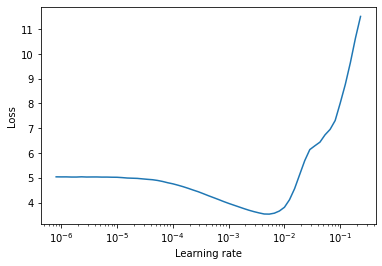

In [12]:
lr_finder.plot()# best lr is in b/w 0.009 and 0.1

In [0]:
lr_finder.reset()

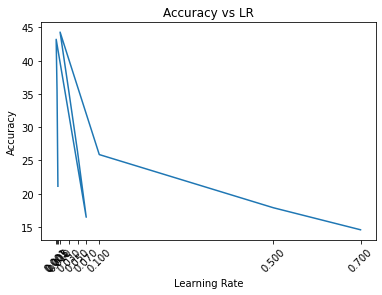

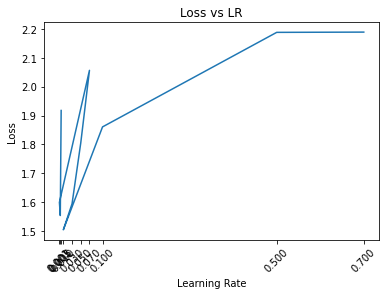

In [14]:
criterion1 = nn.NLLLoss()
import copy
import os
import torch
from tqdm.autonotebook import tqdm
import torch.optim as optim
import torch.nn as nn 
from torch.optim.lr_scheduler import _LRScheduler
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader



LR_List = []
Acc_List = []
Loss_List = []
def lr_rangetest(device, 
                model,
                trainloader, 
                criterion,
                weight_decay=0.05,
                pltTest=True):
    """
    Args:-
    """
    lrs = [5e-3, 3e-3, 1e-3, 7e-2, 5e-2, 3e-2, 1e-2, 1e-1, 5e-1, 7e-1]
    testModel = copy.deepcopy(model)
    for e in range(1,len(lrs)+1):
        optimizer = optim.SGD(testModel.parameters(), lr = lrs[e-1], momentum=0.9, weight_decay=weight_decay)
        # lr_step = (maxlr-minlr)/epochs
        
        testModel.train()
        pbar = tqdm(trainloader)
        correct, processed = 0, 0
        for batch_idx, (data, target) in enumerate(pbar):
            lr = lrs[e-1]
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            y_pred = testModel(data)
            loss = criterion(y_pred, target)
            loss.backward()
            optimizer.step()

            pred = y_pred.argmax(dim=1, keepdim=True)
            correct = correct + pred.eq(target.view_as(pred)).sum().item()
            processed = processed + len(data)
           
            pbar.set_description(desc=f'EPOCH:- {e}, LR={round(optimizer.param_groups[0]["lr"],3)}, Accuracy={100*correct/processed:0.2f}')
        Acc_List.append(100*correct/processed)
        LR_List.append(optimizer.param_groups[0]['lr'])
        Loss_List.append(loss)
    
    if pltTest:
    #     # with plt.style.context('fivethirtyeight'):
    #         # fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(5, 3))
          
            plt.plot(LR_List, Acc_List)
            plt.xticks(lrs, rotation=45)
            plt.xlabel('Learning Rate')
            plt.ylabel('Accuracy')
            plt.title('Accuracy vs LR')
            plt.show()

            # plt.subplot(2,1,2, figsize=(10,4))
            plt.plot(LR_List, Loss_List)
            plt.xticks(lrs, rotation=45)
            plt.xlabel('Learning Rate')
            plt.ylabel('Loss')
            plt.title('Loss vs LR')
            plt.show()




lr_rangetest(device, model, trainLoader, criterion)

In [15]:
LR_List

[0.005, 0.003, 0.001, 0.07, 0.05, 0.03, 0.01, 0.1, 0.5, 0.7]

**Cyclic LR**

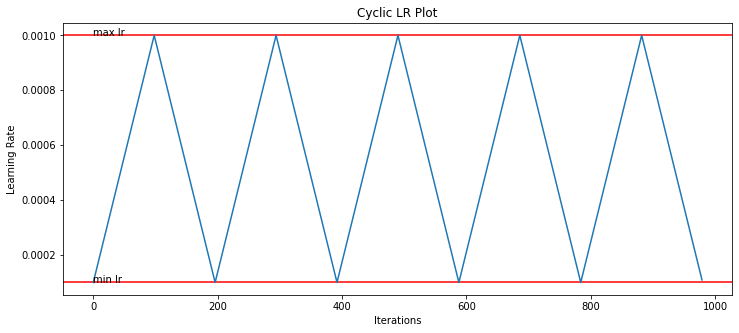

In [16]:
clr1 = clr.CyclicLR(0.001, 0.0001, len(trainLoader), len(trainLoader)*10)
clr1.cyclic_lr(plotGraph=True)

In [0]:
from tqdm import tqdm
import numpy as np
import torch.nn.functional as F
import torch


class Test_Train():
  def __init__(self, 
              model,
              device,
              optimizer,
              scheduler,
              criterion):
    """
    Args:-
    model: Wrapped Model
    device: Device set
    optimizer: Wrapped optimizer
    criterion: Wrapped Loss Function 
    """

    self.model = model
    self.device = device
    self.optimizer = optimizer
    self.criterion = criterion
    self.scheduler = scheduler

# This is to hold all the values and plot some graphs to extract few good insights.
    self.train_losses = []
    self.test_losses = []
    self.train_acc = []
    self.test_acc = []
    self.train_epoch_end = []
    self.test_loss_min = np.inf # setting it to infinity(max value)
    # when the test loss becomes min I will save the particular model


  def train(self, 
            trainloader, 
            epoch,
            L1lambda=None):
    """
    Args:-
    trainLoader: Dataloader for Train Dataset
    epoch: Number of Epochs
    L1lambda: L1lambda Value, by default set to None
    """


    self.model.train()    # prepare model for training
    pbar = tqdm(trainloader)
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar): # passing on data & target values to device
      data, target = data.to(self.device), target.to(self.device)
      self.optimizer.zero_grad()    # clear the gradients of all optimized variables

      # Predict
      y_pred = self.model(data)   # forward pass

      # Calculate loss
      c_loss = self.criterion(y_pred, target)

      #Implementing L1 Regularization
      if L1lambda:
        with torch.enable_grad():
          l1_loss = 0.
          for param in self.model.parameters():
            l1_loss += torch.sum(param.abs())
          loss = c_loss +  (L1lambda * l1_loss)


      loss.backward()   # backward pass: compute gradient of the loss with respect to model parameters
      self.optimizer.step()   # perform a single optimization step (parameter update)

      # Update pbar-tqdm

      pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
      correct += pred.eq(target.view_as(pred)).sum().item()
      processed += len(data)

      pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    self.train_acc.append(100*correct/processed)
    self.scheduler.step()
    self.train_epoch_end.append(self.train_acc[-1])
    self.train_losses.append(loss)


  def test(self, 
          testloader, 
          filename, 
          correct_samples, 
          correctLabels, 
          incorrect_samples):
      """
      Args:
      1. TestLoader: Dataloader for Test Dataset
      2. filename: I don't remember why I added this?
      3. correct_samples: Containers with Correctly Classified Images
      4. correctLabels: Containers with Correct Labels
      5. incorrect_samples: Containers with Incorrectly Classified Images
      """
      
      self.model.eval()  # prep model for evaluation
      test_loss = 0
      correct = 0

      with torch.no_grad(): # setting gradients back to zero
          for data, target in testloader:

            img_batch = data # this is done to store data
            data, target = data.to(self.device), target.to(self.device)

            # forward pass: compute predicted outputs by passing inputs to the model
            output = self.model(data)

            # sum up batch loss
            # test_loss += F.nll_loss(output, target, reduction='sum').item()
            test_loss = self.criterion(output, target).item()


            # get the index of the max log-probability
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

            # storing the entire result data as binary
            result = pred.eq(target.view_as(pred))
            # self.scheduler.step()

            # This is to extract incorrect samples/misclassified images
            if len(incorrect_samples) < 25:
              for i in range(0, testloader.batch_size):
                if not list(result)[i]:
                  incorrect_samples.append({'prediction': list(pred)[i], 'label': list(target.view_as(pred))[i],'image': img_batch[i]})


            # this is to extract correct samples/classified images
            if len(correct_samples) < 25:
              for i in range(0, testloader.batch_size):
                if list(result)[i]:
                  correct_samples.append({'prediction': list(pred)[i], 'label': list(target.view_as(pred))[i],'image': img_batch[i]})
                  correctLabels.append(list(target.view_as(pred))[i]) # this is for gradcam



      # save model if validation loss has decreased
      if test_loss <= self.test_loss_min:
          print('Validation loss has  decreased ({:.4f} --> {:.4f}).  Saving model ...'.format(self.test_loss_min,test_loss ))
          torch.save(self.model.state_dict(), filename)
          self.test_loss_min = test_loss


      print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
          test_loss, correct, len(testloader.dataset),
          100. * correct / len(testloader.dataset)))


      self.test_acc.append(100. * correct / len(testloader.dataset))
      self.test_losses.append(test_loss)



def cross_entropy_loss():
    """Returns:
        Cross entroy loss function
    """
    return torch.nn.CrossEntropyLoss()


**Modelling**

In [19]:
incorrectSamples = []
correctSamples = []
correctLabels = []
learningRates = []
model = customNet.main11().to(device)

criterion = cross_entropy_loss()
optimizer = optim.SGD(model.parameters(), lr = 1e-3, momentum=0.9, weight_decay=1e-4, nesterov = True) 
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr = 1e-2, epochs = 5, steps_per_epoch=len(trainLoader),
                                                pct_start=0.20, anneal_strategy='linear', cycle_momentum=False, div_factor=10.0, final_div_factor=1)

#OneCycleLR(optimizer, max_lr = 0.0125, total_steps=None, epochs=24, steps_per_epoch=len(trainloader), 
#pct_start=0.167, anneal_strategy='linear', cycle_momentum=False, base_momentum=0.85, max_momentum=0.95, div_factor=10.0,final_div_factor =1)

model1 = Test_Train(model, device, optimizer, scheduler, criterion)
EPOCHS = 5


for epoch in range(1, EPOCHS+1):
  print('EPOCH: ',epoch)
  model1.train(trainLoader, epoch, L1lambda = 1e-5 )
  model1.test(testLoader, 'model1.pt', correctSamples, correctLabels, incorrectSamples)
  # scheduler.step(model1.test_losses[-1])
  for param_group in optimizer.param_groups:
    print('Learning Rate = {a} for EPOCH {e}'.format(a = round(param_group['lr'],4), e=epoch+1))
    learningRates.append(param_group['lr'])


  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH:  1



Loss=5.429974555969238 Batch_id=0 Accuracy=6.45:   0%|          | 0/98 [00:01<?, ?it/s]
Loss=5.429974555969238 Batch_id=0 Accuracy=6.45:   1%|          | 1/98 [00:01<01:48,  1.11s/it]
Loss=3.9475605487823486 Batch_id=1 Accuracy=8.50:   1%|          | 1/98 [00:01<01:48,  1.11s/it]
Loss=3.9475605487823486 Batch_id=1 Accuracy=8.50:   2%|▏         | 2/98 [00:01<01:19,  1.20it/s]
Loss=3.7983055114746094 Batch_id=2 Accuracy=9.57:   2%|▏         | 2/98 [00:01<01:19,  1.20it/s]
Loss=3.7983055114746094 Batch_id=2 Accuracy=9.57:   3%|▎         | 3/98 [00:01<01:00,  1.58it/s]
Loss=4.4818243980407715 Batch_id=3 Accuracy=11.43:   3%|▎         | 3/98 [00:01<01:00,  1.58it/s]
Loss=4.4818243980407715 Batch_id=3 Accuracy=11.43:   4%|▍         | 4/98 [00:01<00:45,  2.05it/s]
Loss=3.731992721557617 Batch_id=4 Accuracy=11.88:   4%|▍         | 4/98 [00:02<00:45,  2.05it/s] 
Loss=3.731992721557617 Batch_id=4 Accuracy=11.88:   5%|▌         | 5/98 [00:02<00:42,  2.17it/s]
Loss=3.625256061553955 Batch_id=5 Ac

Validation loss has  decreased (inf --> 1.4283).  Saving model ...

Test set: Average loss: 1.4283, Accuracy: 4595/10000 (45.95%)

Learning Rate = 0.0010927835051546392 for EPOCH 2
EPOCH:  2



Loss=2.1015896797180176 Batch_id=0 Accuracy=42.58:   0%|          | 0/98 [00:01<?, ?it/s]
Loss=2.1015896797180176 Batch_id=0 Accuracy=42.58:   1%|          | 1/98 [00:01<01:38,  1.02s/it]
Loss=2.1352744102478027 Batch_id=1 Accuracy=42.38:   1%|          | 1/98 [00:01<01:38,  1.02s/it]
Loss=2.1352744102478027 Batch_id=1 Accuracy=42.38:   2%|▏         | 2/98 [00:01<01:13,  1.31it/s]
Loss=2.055539846420288 Batch_id=2 Accuracy=44.08:   2%|▏         | 2/98 [00:01<01:13,  1.31it/s] 
Loss=2.055539846420288 Batch_id=2 Accuracy=44.08:   3%|▎         | 3/98 [00:01<00:55,  1.71it/s]
Loss=2.1363580226898193 Batch_id=3 Accuracy=44.19:   3%|▎         | 3/98 [00:01<00:55,  1.71it/s]
Loss=2.1363580226898193 Batch_id=3 Accuracy=44.19:   4%|▍         | 4/98 [00:01<00:42,  2.19it/s]
Loss=2.133298873901367 Batch_id=4 Accuracy=44.45:   4%|▍         | 4/98 [00:01<00:42,  2.19it/s] 
Loss=2.133298873901367 Batch_id=4 Accuracy=44.45:   5%|▌         | 5/98 [00:01<00:40,  2.32it/s]
Loss=2.1636111736297607 Batch

Validation loss has  decreased (1.4283 --> 1.2283).  Saving model ...

Test set: Average loss: 1.2283, Accuracy: 5567/10000 (55.67%)

Learning Rate = 0.0011855670103092784 for EPOCH 3
EPOCH:  3



Loss=1.7987899780273438 Batch_id=0 Accuracy=57.81:   0%|          | 0/98 [00:01<?, ?it/s]
Loss=1.7987899780273438 Batch_id=0 Accuracy=57.81:   1%|          | 1/98 [00:01<01:53,  1.17s/it]
Loss=1.8914330005645752 Batch_id=1 Accuracy=55.37:   1%|          | 1/98 [00:01<01:53,  1.17s/it]
Loss=1.8914330005645752 Batch_id=1 Accuracy=55.37:   2%|▏         | 2/98 [00:01<01:23,  1.15it/s]
Loss=1.916137456893921 Batch_id=2 Accuracy=54.30:   2%|▏         | 2/98 [00:01<01:23,  1.15it/s] 
Loss=1.916137456893921 Batch_id=2 Accuracy=54.30:   3%|▎         | 3/98 [00:01<01:02,  1.52it/s]
Loss=1.9179277420043945 Batch_id=3 Accuracy=53.27:   3%|▎         | 3/98 [00:01<01:02,  1.52it/s]
Loss=1.9179277420043945 Batch_id=3 Accuracy=53.27:   4%|▍         | 4/98 [00:01<00:47,  1.96it/s]
Loss=1.823289155960083 Batch_id=4 Accuracy=53.83:   4%|▍         | 4/98 [00:02<00:47,  1.96it/s] 
Loss=1.823289155960083 Batch_id=4 Accuracy=53.83:   5%|▌         | 5/98 [00:02<00:44,  2.08it/s]
Loss=1.905188798904419 Batch_

Validation loss has  decreased (1.2283 --> 1.2026).  Saving model ...

Test set: Average loss: 1.2026, Accuracy: 5832/10000 (58.32%)

Learning Rate = 0.0012783505154639176 for EPOCH 4
EPOCH:  4



Loss=1.7987866401672363 Batch_id=0 Accuracy=57.23:   0%|          | 0/98 [00:01<?, ?it/s]
Loss=1.7987866401672363 Batch_id=0 Accuracy=57.23:   1%|          | 1/98 [00:01<01:41,  1.04s/it]
Loss=1.8268787860870361 Batch_id=1 Accuracy=56.25:   1%|          | 1/98 [00:01<01:41,  1.04s/it]
Loss=1.8268787860870361 Batch_id=1 Accuracy=56.25:   2%|▏         | 2/98 [00:01<01:15,  1.28it/s]
Loss=1.8507534265518188 Batch_id=2 Accuracy=55.60:   2%|▏         | 2/98 [00:01<01:15,  1.28it/s]
Loss=1.8507534265518188 Batch_id=2 Accuracy=55.60:   3%|▎         | 3/98 [00:01<00:57,  1.67it/s]
Loss=1.7584969997406006 Batch_id=3 Accuracy=56.74:   3%|▎         | 3/98 [00:01<00:57,  1.67it/s]
Loss=1.7584969997406006 Batch_id=3 Accuracy=56.74:   4%|▍         | 4/98 [00:01<00:44,  2.12it/s]
Loss=1.7422826290130615 Batch_id=4 Accuracy=57.38:   4%|▍         | 4/98 [00:01<00:44,  2.12it/s]
Loss=1.7422826290130615 Batch_id=4 Accuracy=57.38:   5%|▌         | 5/98 [00:01<00:39,  2.33it/s]
Loss=1.7718958854675293 Bat

Validation loss has  decreased (1.2026 --> 0.9908).  Saving model ...

Test set: Average loss: 0.9908, Accuracy: 6186/10000 (61.86%)

Learning Rate = 0.0013711340206185568 for EPOCH 5
EPOCH:  5



Loss=1.7333406209945679 Batch_id=0 Accuracy=58.59:   0%|          | 0/98 [00:01<?, ?it/s]
Loss=1.7333406209945679 Batch_id=0 Accuracy=58.59:   1%|          | 1/98 [00:01<01:53,  1.17s/it]
Loss=1.6827309131622314 Batch_id=1 Accuracy=60.55:   1%|          | 1/98 [00:01<01:53,  1.17s/it]
Loss=1.6827309131622314 Batch_id=1 Accuracy=60.55:   2%|▏         | 2/98 [00:01<01:23,  1.16it/s]
Loss=1.7037968635559082 Batch_id=2 Accuracy=60.55:   2%|▏         | 2/98 [00:01<01:23,  1.16it/s]
Loss=1.7037968635559082 Batch_id=2 Accuracy=60.55:   3%|▎         | 3/98 [00:01<01:02,  1.53it/s]
Loss=1.6455435752868652 Batch_id=3 Accuracy=61.23:   3%|▎         | 3/98 [00:01<01:02,  1.53it/s]
Loss=1.6455435752868652 Batch_id=3 Accuracy=61.23:   4%|▍         | 4/98 [00:01<00:47,  1.97it/s]
Loss=1.591763973236084 Batch_id=4 Accuracy=62.07:   4%|▍         | 4/98 [00:02<00:47,  1.97it/s] 
Loss=1.591763973236084 Batch_id=4 Accuracy=62.07:   5%|▌         | 5/98 [00:02<00:43,  2.12it/s]
Loss=1.7080891132354736 Batc

Validation loss has  decreased (0.9908 --> 0.9772).  Saving model ...

Test set: Average loss: 0.9772, Accuracy: 6454/10000 (64.54%)

Learning Rate = 0.001463917525773196 for EPOCH 6


**Plot Train & Test Curves**

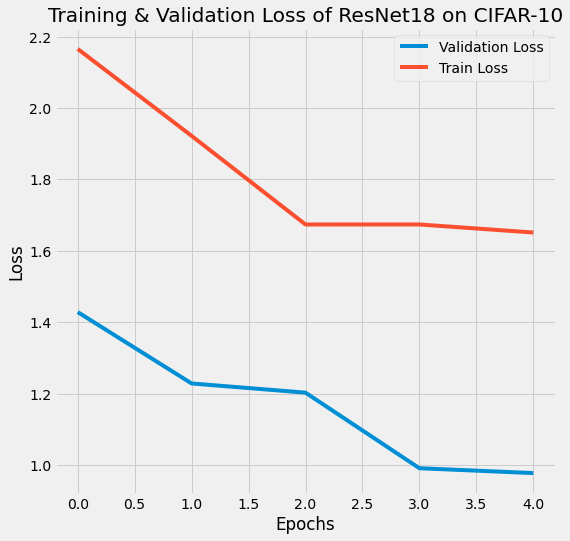

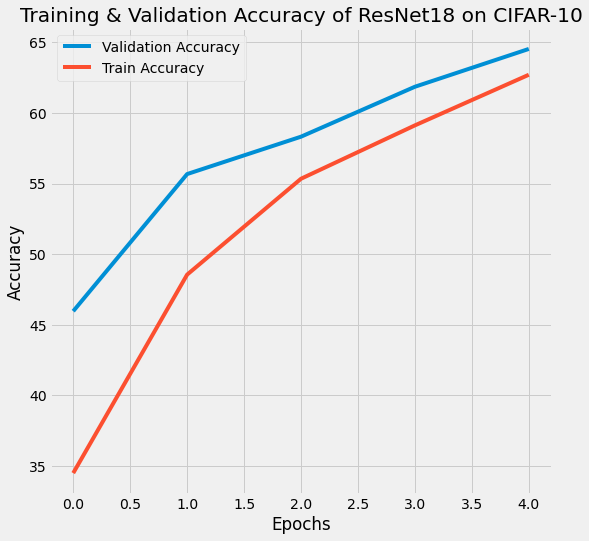

In [20]:
accuracyElements = [(model1.test_acc,"Validation Accuracy"),(model1.train_epoch_end,"Train Accuracy")]
lossElements = [(model1.test_losses,"Validation Loss"),(model1.train_losses,"Train Loss")]

for i in range(1):
  display.plot_curve(lossElements,'Training & Validation Loss of ResNet18 on CIFAR-10', y_label='Loss')
  display.plot_curve(accuracyElements,'Training & Validation Accuracy of ResNet18 on CIFAR-10')

**Misclassified Images**

In [0]:
display.misclassified_ones(model, testLoader, incorrectSamples,'MisclassfiedOnes.png')

#GradCam Implementation

**GradCam Input Data**

In [0]:
images = [x['image'] for x in incorrectSamples[10:35]] # Extracting MisClassified Images
target_classes = [l['label'] for l in incorrectSamples[10:35]] # Target Classes
predicted_classes = [p['prediction'] for p in incorrectSamples[10:35]] # Predicted Classes
targetLabels = [classes[t] for t in target_classes] # Target Labels
predLabels = [classes[p] for p in predicted_classes] # Predicted Labels


**GradCam Core** 

In [0]:
model = ResNet18().to(device)
image_size = (3,32,32) # set image size

target_layers = ["layer1", "layer2", "layer3", "layer4"]
print('IMPLEMENTING GRADCAM FOR SET1[...]')
gradcam_output, probs, predicted_classes = gdc.GRADCAM(images, device, target_classes, model, target_layers) 
gdc.PLOT(gradcam_output, images, target_layers, image_size, display.unnormalize, targetLabels, predLabels) # Plot the gradcam_output for the target layers
